In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phems-hackathon-early-sepsis-prediction/SepsisLabel_sample_submission.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/drugsexposure_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/observation_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/devices_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/measurement_lab_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/proceduresoccurrences_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/person_demographics_episode_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/SepsisLabel_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/measurement_observation_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/measurement_meds_train.csv
/kaggle/input/phems-hackathon-early-sepsis-prediction/tes

#  Predicting Pediatric Sepsis Using Data Science

## Introduction
Sepsis is a critical medical condition that requires early detection for effective treatment, especially in pediatric patients. This project aims to predict sepsis using advanced machine learning techniques on diverse patient data. By integrating data from medical devices, drug exposure, laboratory tests, and patient demographics, we built a robust pipeline to make early and accurate predictions.

## The Journey
### 1. Data Exploration
We started by loading datasets containing patient data:
- **Devices and Drugs**: Usage of medical devices and administered drugs provided insights into the treatment process.
- **Lab Measurements**: Offered detailed observations of physiological metrics.
- **Demographics**: Highlighted key information like age and gender.
- **Sepsis Labels**: Indicated whether a patient developed sepsis during their ICU stay.

### 2. Feature Engineering
To make the data usable for machine learning:
- Time-series data was aggregated at the patient level to summarize trends.
- Demographic data was processed to include numeric features like age.
- Missing values were handled gracefully to ensure clean input for the model.

### 3. Model Development
We trained a **LightGBM classifier**, a powerful gradient boosting algorithm, to predict sepsis. The model was evaluated using:
- **Precision-Recall AUC**: To measure performance in handling imbalanced datasets.
- **Accuracy and F1 Score**: To gauge overall and balanced predictive power.

### 4. Visual Insights
To complement the model:
- **Precision-Recall Curve**: Showed how well the model distinguishes between sepsis and non-sepsis cases.
- **Feature Importance**: Identified key contributors to predictions, like lab values and demographic features.
- **Heatmap**: Illustrated correlations between features, revealing patterns in patient data.
- **Sepsis Rates by Age and Gender**: Highlighted which groups are most at risk, aiding targeted interventions.

## Key Findings
1. **Age-Related Risks**: Certain age groups, like infants and young children, showed higher rates of sepsis.
2. **Gender Disparities**: Gender differences in sepsis rates were observed, prompting further exploration.
3. **Critical Features**: Lab measurements and specific observations played a pivotal role in predictions.

## Impact
This project equips clinicians with a tool to identify high-risk pediatric patients early, potentially saving lives through timely interventions. The flexible pipeline can adapt to other ICU datasets, expanding its utility.

## Next Steps
- Expand analysis to include additional features like comorbidities.
- Test the model on real-world ICU data for validation.
- Optimize the pipeline for faster predictions in clinical settings.

By integrating data science and medicine, this project is a step towards smarter, data-driven healthcare.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
path = "/kaggle/input/phems-hackathon-early-sepsis-prediction/training_data/"

# Load individual datasets
# Each dataset represents different aspects of patient data (devices, drug exposure, lab measurements, etc.)
devices_train = pd.read_csv(path + "devices_train.csv")
drugexposure_train = pd.read_csv(path + "drugsexposure_train.csv")
measurements_lab_train = pd.read_csv(path + "measurement_lab_train.csv")
observations_train = pd.read_csv(path + "observation_train.csv")
person_demographics = pd.read_csv(path + "person_demographics_episode_train.csv")
outcome_train = pd.read_csv(path + "SepsisLabel_train.csv")

# Helper Functions
def aggregate_time_series(data, time_col, group_col, agg_features):
    """Aggregate time-series data for feature generation."""
    # Ensure numeric columns are properly converted
    numeric_cols = [col for col, agg in agg_features.items() if 'mean' in agg or 'std' in agg or 'min' in agg or 'max']
    data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
    agg_data = data.groupby(group_col).agg(agg_features)
    agg_data.columns = ["_".join(col).strip() for col in agg_data.columns.values]  # Flatten MultiIndex
    return agg_data.reset_index()



In [3]:
# Feature Engineering
# Define aggregation dictionary for observations
agg_dict_observations = {
    'valuefilled': ['mean', 'std', 'min', 'max'],  # Statistics on measured values
    'observation_concept_id': ['nunique']  # Count of unique observation types
}

# Convert 'valuefilled' column to numeric and handle non-numeric values
observations_train['valuefilled'] = pd.to_numeric(observations_train['valuefilled'], errors='coerce')

# Aggregate time-series observations at patient level
observations_agg = aggregate_time_series(observations_train, 'observation_datetime', 'person_id', agg_dict_observations)

# Process demographic data (e.g., age, gender)
demographics_numeric = person_demographics.select_dtypes(include=[np.number])
demographics_numeric['person_id'] = person_demographics['person_id']
demographics_agg = demographics_numeric.groupby('person_id').mean().reset_index()

# Select outcome labels (sepsis or not)
outcome_data = outcome_train[['person_id', 'SepsisLabel']]

# Merge datasets into a single DataFrame for training
combined_data = outcome_data.merge(observations_agg, on='person_id', how='left')
combined_data = combined_data.merge(demographics_agg, on='person_id', how='left')
combined_data.fillna(0, inplace=True)  # Fill missing values with 0

In [4]:
# Train-Test Split
# Separate features (X) and labels (y)
X = combined_data.drop(columns=['person_id', 'SepsisLabel'])
y = combined_data['SepsisLabel']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
# Initialize LightGBM model with basic parameters
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='pr_auc', n_estimators=100, random_state=42)

# Train the model with early stopping to prevent overfitting
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)],  # Use validation set for evaluation
    eval_metric='auc',  # Metric to evaluate (AUC)
    callbacks=[lgb.early_stopping(stopping_rounds=10)]  # Stop if performance doesn't improve in 10 rounds
)

[LightGBM] [Info] Number of positive: 5524, number of negative: 259798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 265322, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020820 -> initscore=-3.850802
[LightGBM] [Info] Start training from score -3.850802
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.957993


LGBMClassifier(metric='pr_auc', objective='binary', random_state=42)

In [5]:
# Predictions and Metrics
# Generate predictions (probabilities) for the validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

# Calculate area under the precision-recall curve
pr_auc = auc(recall, precision)

# Calculate additional metrics
accuracy = accuracy_score(y_val, (y_pred_proba > 0.5).astype(int))  # Accuracy at threshold 0.5
f1 = f1_score(y_val, (y_pred_proba > 0.5).astype(int))  # F1 Score

# Print evaluation metrics
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision-Recall AUC: 0.2990
Accuracy: 0.9798
F1 Score: 0.0261


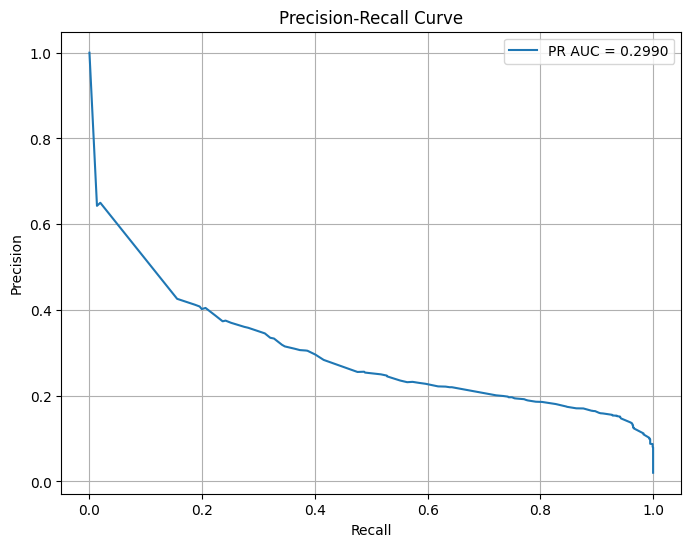

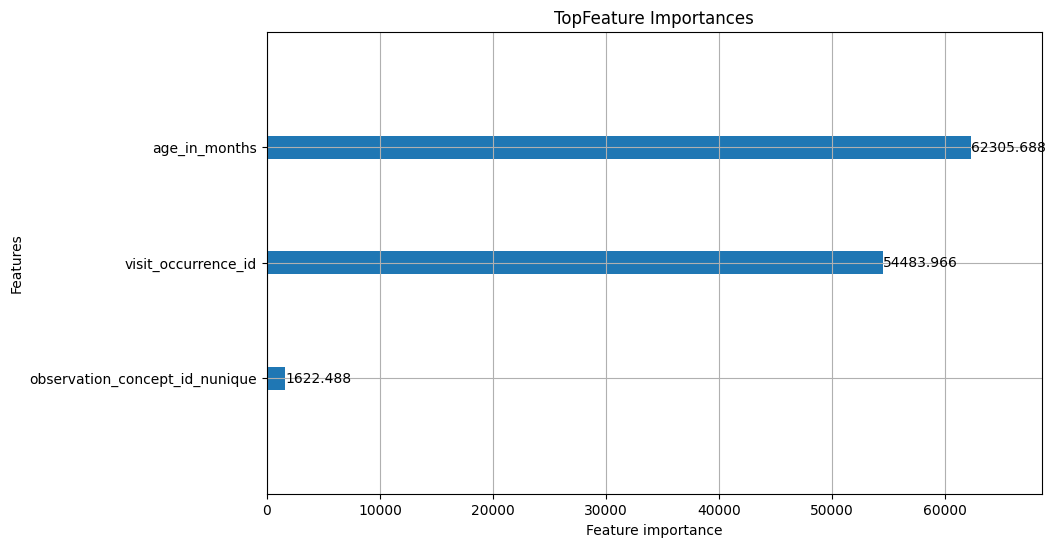

In [6]:

# Visualizations
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Feature Importance
# Plot feature importance to interpret model
lgb.plot_importance(model, max_num_features=3, importance_type='gain', figsize=(10, 6))
plt.title("TopFeature Importances")
plt.show()


In [7]:
# Analyze sepsis rate by age
age_bins = [0, 12, 36, 72, 120, 180, 240]  # Age in months (e.g., 0-1 year, 1-3 years, etc.)
age_labels = ['0-1yr', '1-3yr', '3-6yr', '6-10yr', '10-15yr', '>15yr']
age_gender_data['age_group'] = pd.cut(age_gender_data['age_in_months'], bins=age_bins, labels=age_labels)
age_sepsis_rate = age_gender_data.groupby('age_group')['SepsisLabel'].mean()

# Plot sepsis rate by age group
plt.figure(figsize=(8, 6))
age_sepsis_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Age Group')
plt.ylabel('Sepsis Rate')
plt.title('Sepsis Rate by Age Group')
plt.grid(axis='y')
plt.show()

NameError: name 'age_gender_data' is not defined

In [ ]:

# Analyze sepsis rate by gender
gender_sepsis_rate = age_gender_data.groupby('gender')['SepsisLabel'].mean()

# Plot sepsis rate by gender
plt.figure(figsize=(6, 6))
gender_sepsis_rate.plot(kind='bar', color='salmon', edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Sepsis Rate')
plt.title('Sepsis Rate by Gender')
plt.grid(axis='y')
plt.show()